In [58]:
#import all the necessary libraries
import warnings
warnings.filterwarnings("ignore")

import pickle

from numpy import mean
from numpy import std
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss
import matplotlib.pyplot as plt

import en_core_web_sm
from spacy.lang.en.stop_words import STOP_WORDS
#nlp = en_core_web_sm.load()

In [59]:
filename = "/Users/HOME/Desktop/Springboard/TED-Talks/Models/ted_encoded.pkl"
ted_sentiment = pd.read_pickle(filename)
ted_sentiment.head()

,duration,languages,num_speaker,event_0,event_1,event_2,event_3,event_4,event_5,event_6,...,underwater,universe,vehicle,video,violence,virus,wall,war,web,whale
0,19.400000,60,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,16.283333,43,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,21.433333,26,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,18.600000,35,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,19.833333,48,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
#Split the dataset into train and test 
from sklearn.model_selection import train_test_split
X = ted_sentiment.drop(['rating','sentiment'],axis = 1)
y = ted_sentiment['rating']
                       
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=123,stratify = y)

In [31]:
#BoW method - CountVectorizer on clean_transc feature
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

cv = CountVectorizer(strip_accents = 'ascii',stop_words = STOP_WORDS)
cv_train = cv.fit_transform(X_train['clean_transc'])
transc = pd.DataFrame(cv_train.todense(),columns=cv.get_feature_names())
X_train = pd.concat([X_train.drop('clean_transc', axis=1),transc.set_index(X_train.index)], axis=1)

cv_test = cv.transform(X_test['clean_transc'])
test_transc = pd.DataFrame(cv_test.todense(),columns=cv.get_feature_names())
X_test = pd.concat([X_test.drop('clean_transc', axis=1),test_transc.set_index(X_test.index)], axis=1)
X_train.shape,X_test.shape


((1718, 41745), (737, 41745))

In [ ]:
#Tf-idf Vectorizer on clean_transc feature
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

tv = TfidfVectorizer(strip_accents = 'ascii',stop_words = STOP_WORDS)
tv_train = tv.fit_transform(X_train['clean_transc'])
transc = pd.DataFrame(tv_train.todense(),columns=tv.get_feature_names())
X_train = pd.concat([X_train.drop('clean_transc', axis=1),transc.set_index(X_train.index)], axis=1)

tv_test = tv.transform(X_test['clean_transc'])
test_transc = pd.DataFrame(tv_test.todense(),columns=tv.get_feature_names())
X_test = pd.concat([X_test.drop('clean_transc', axis=1),test_transc.set_index(X_test.index)], axis=1)
X_train.shape,X_test.shape

### Latent Senmantic Analysis (LSA)

- The idea is that words will occurs in similar pieces of text if they have similar meaning. People usually use Latent Semantic Indexing (LSI) as an alternative name in NLP field.

- First of all, we have m documents and n words as input. An m * n matrix can be constructed while column and row are document and word respectively. You can use count occurrence or TF-IDF score. However, TF-IDF is better than count occurrence in most of the time as high frequency do not account for better classification.

- The idea of TF-IDF is that high frequency may not able to provide much information gain. In another word, rare words contribute more weights to the model. Word importance will be increased if the number of occurrence within same document (i.e. training record). On the other hand, it will be decreased if it occurs in corpus (i.e. other training records).

- The challenge is that the matrix is very sparse (or high dimension) and noisy (or include lots of low frequency word). So truncated SVD is adopted to reduce dimension.


- The idea of SVD is finding the most valuable information and using lower dimension t to represent same thing.

In [61]:
#Building LSA model for dimentionality reduction
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

def build_lsa(x_train, x_test, dim=50):
    tfidf_vec = TfidfVectorizer(strip_accents = 'ascii',stop_words = STOP_WORDS,use_idf=True, norm='l2')
    #cv_vec = CountVectorizer(strip_accents = 'ascii',stop_words = STOP_WORDS)
    svd = TruncatedSVD(n_components=dim,random_state=1)
    
    transformed_x_train = tfidf_vec.fit_transform(x_train['clean_transc'])
    transformed_x_test = tfidf_vec.transform(x_test['clean_transc'])
    
    print('TF-IDF train output shape:', transformed_x_train.shape)
    print('TF-IDF test output shape:', transformed_x_test.shape)
    
    x_train_svd = svd.fit_transform(transformed_x_train)
    x_test_svd = svd.transform(transformed_x_test)
    
    print('LSA train output shape:', x_train_svd.shape)
    print('LSA test output shape:', x_test_svd.shape)
    
    
    transc = pd.DataFrame(x_train_svd)
    x_train = pd.concat([X_train.drop('clean_transc', axis=1),transc.set_index(X_train.index)], axis=1)
    print("Trainging data shape:", x_train.shape)
    
    test_transc = pd.DataFrame(x_test_svd)
    x_test = pd.concat([X_test.drop('clean_transc', axis=1),test_transc.set_index(X_test.index)], axis=1)
    print("Test data shape:",x_test.shape)
    
    explained_variance = svd.explained_variance_ratio_.sum()
    print("Sum of explained variance ratio: %d%%" % (int(explained_variance * 100)))
    
    
    return tfidf_vec, svd, x_train_svd, x_test_svd


tfidf_vec, svd, x_train, x_test = build_lsa(X_train, X_test)


TF-IDF train output shape: (1718, 37716)
TF-IDF test output shape: (737, 37716)
LSA train output shape: (1718, 50)
LSA test output shape: (737, 50)
Trainging data shape: (1718, 4079)
Test data shape: (737, 4079)
Sum of explained variance ratio: 14%


### MULTICLASS CLASSIFICATION 

### Define evaluation procedure

>SVM 0.345 (0.001)
>KNN 0.478 (0.019)
>RF 0.532 (0.017)
>SGDC 0.530 (0.038)
>LogReg 0.529 (0.021)


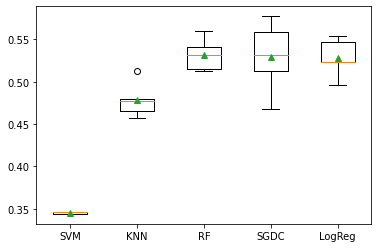

In [62]:
# define evaluation procedure
def evaluate_model(X, y, model):
    cv = StratifiedKFold(n_splits = 5, shuffle=False, random_state = 1)
    # evaluate model
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    
    return scores


# define models to test
def get_models():
    models, names = list(), list()
    # SVM
    models.append(SVC(gamma='auto'))
    names.append('SVM')
    
    # KNN
    models.append(KNeighborsClassifier())
    names.append('KNN')
    
    # RF
    models.append(RandomForestClassifier())
    names.append('RF')
    
    # svm
    models.append(SGDClassifier(loss='hinge'))
    names.append('SGDC')
    
    #LogisticRegression
    models.append(LogisticRegression())
    names.append('LogReg')
    
    #XGB
    #models.append(xgb.XGBClassifier(objective='multi:softmax',n_estimators = 500))
    #names.append('XGB')
    return models, names

# define models
models, names = get_models()
results = list()


# evaluate each model
for i in range(len(models)):
    # evaluate the model and store results
    scores = evaluate_model(x_train, y_train, models[i])
    results.append(scores)
    # summarize performance
    print('>%s %.3f (%.3f)' % (names[i], mean(scores), std(scores)))
    
# plot the results
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

Here we are going to try two models with Randomforest classifier and SGDClassifier.

### MODEL - 1 - RANDOM FOREST CLASSIFIER

In [63]:
#RandomForestClassifier 

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=500,random_state = 1,n_jobs=-1)
model_rf = rf.fit(x_train, y_train)

cv = StratifiedKFold(n_splits = 5, shuffle=False, random_state = 1)

# evaluate model
scores = cross_val_score(rf, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

y_pred = model_rf.predict(x_test)
ac = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)
print("train accuracy: ",model_rf.score(x_train,y_train))
print("test accuracy: ", model_rf.score(x_test,y_test))
print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

train accuracy:  1.0
test accuracy:  0.5440976933514247
Random Forest: Accuracy=0.544
Random Forest: f1-score=0.475
              precision    recall  f1-score   support

   Beautiful       0.42      0.12      0.19        40
  Courageous       0.00      0.00      0.00        25
 Fascinating       0.53      0.31      0.39        75
       Funny       0.56      0.19      0.29        47
 Informative       0.51      0.67      0.58       214
   Ingenious       0.00      0.00      0.00        30
   Inspiring       0.57      0.86      0.69       255
Jaw-dropping       0.00      0.00      0.00        14
          OK       0.00      0.00      0.00         2
  Persuasive       0.00      0.00      0.00        24
    negative       0.00      0.00      0.00        11

    accuracy                           0.54       737
   macro avg       0.24      0.20      0.19       737
weighted avg       0.46      0.54      0.48       737

[[  5   0   4   0   9   0  22   0   0   0   0]
 [  0   0   0   0   8   

In [64]:
#RandomForestClassifier with weights(COST-SENSITIVE METHOD)
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)
weights = dict(zip(np.unique(y_train),class_weight))


from sklearn.ensemble import RandomForestClassifier
model_weights = RandomForestClassifier(n_estimators=800,class_weight = weights,random_state = 1,n_jobs=-1)
rf_weight = model_weights.fit(x_train, y_train)

cv = StratifiedKFold(n_splits = 5, shuffle=False, random_state = 1)

# evaluate model
scores = cross_val_score(model_weights, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

y_pred = rf_weight.predict(x_test)
ac = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)
print("train accuracy: ",model_weights.score(x_train,y_train))
print("test accuracy: ", model_weights.score(x_test,y_test))
print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))



train accuracy:  1.0
test accuracy:  0.5440976933514247
Random Forest: Accuracy=0.544
Random Forest: f1-score=0.485
              precision    recall  f1-score   support

   Beautiful       0.53      0.23      0.32        40
  Courageous       0.67      0.08      0.14        25
 Fascinating       0.56      0.27      0.36        75
       Funny       0.62      0.17      0.27        47
 Informative       0.51      0.66      0.58       214
   Ingenious       0.43      0.10      0.16        30
   Inspiring       0.57      0.85      0.68       255
Jaw-dropping       0.00      0.00      0.00        14
          OK       0.00      0.00      0.00         2
  Persuasive       0.00      0.00      0.00        24
    negative       0.00      0.00      0.00        11

    accuracy                           0.54       737
   macro avg       0.35      0.21      0.23       737
weighted avg       0.51      0.54      0.49       737

[[  9   1   3   0   7   0  20   0   0   0   0]
 [  0   2   0   0   8   

### Model 2 -  SGDClassifier

In [65]:
#SGDClassifier

from sklearn.linear_model import SGDClassifier
svm = SGDClassifier(loss='hinge', random_state = 1,n_jobs=-1)
svm_weight = svm.fit(x_train, y_train)

cv = StratifiedKFold(n_splits = 5, shuffle=False, random_state = 1)

# evaluate model
scores = cross_val_score(svm, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

y_pred = svm_weight.predict(x_test)
ac = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)
print("train accuracy: ",svm_weight.score(x_train,y_train))
print("test accuracy: ", svm_weight.score(x_test,y_test))
print('SGD: Accuracy=%.3f' % (ac))

print('SGD: f1-score=%.3f' % (f1))

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))



train accuracy:  0.5745052386495926
test accuracy:  0.5603799185888738
SGD: Accuracy=0.560
SGD: f1-score=0.527
              precision    recall  f1-score   support

   Beautiful       0.43      0.30      0.35        40
  Courageous       0.50      0.04      0.07        25
 Fascinating       0.29      0.55      0.38        75
       Funny       0.50      0.15      0.23        47
 Informative       0.56      0.79      0.66       214
   Ingenious       0.25      0.07      0.11        30
   Inspiring       0.77      0.70      0.73       255
Jaw-dropping       0.00      0.00      0.00        14
          OK       0.00      0.00      0.00         2
  Persuasive       0.20      0.04      0.07        24
    negative       0.00      0.00      0.00        11

    accuracy                           0.56       737
   macro avg       0.32      0.24      0.24       737
weighted avg       0.55      0.56      0.53       737

[[ 12   1  16   0   2   0   9   0   0   0   0]
 [  1   1   1   0  11   0  11

In [67]:
#SGDClassifier with weights(COST-SENSITIVE METHOD)

from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)
weights = dict(zip(np.unique(y_train),class_weight))


from sklearn.linear_model import SGDClassifier
svm = SGDClassifier(loss='hinge', random_state = 1,n_jobs=-1,class_weight = weights)

svm_weight = svm.fit(x_train, y_train)

cv = StratifiedKFold(n_splits = 5, shuffle=False, random_state = 1)

# evaluate model
scores = cross_val_score(svm, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

y_pred = svm_weight.predict(x_test)
#predicted_prob = svm_weight.predict_proba(x_test)
ac = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)
print("train accuracy: ",svm_weight.score(x_train,y_train))
print("test accuracy: ", svm_weight.score(x_test,y_test))
print('sgd: Accuracy=%.3f' % (ac))

print('sgd: f1-score=%.3f' % (f1))

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


train accuracy:  0.4935972060535506
test accuracy:  0.4151967435549525
sgd: Accuracy=0.415
sgd: f1-score=0.424
              precision    recall  f1-score   support

   Beautiful       0.22      0.57      0.32        40
  Courageous       0.26      0.40      0.31        25
 Fascinating       0.24      0.47      0.32        75
       Funny       0.29      0.04      0.07        47
 Informative       0.54      0.62      0.58       214
   Ingenious       0.29      0.27      0.28        30
   Inspiring       0.87      0.35      0.50       255
Jaw-dropping       0.08      0.14      0.10        14
          OK       0.00      0.00      0.00         2
  Persuasive       0.12      0.17      0.14        24
    negative       0.00      0.00      0.00        11

    accuracy                           0.42       737
   macro avg       0.26      0.28      0.24       737
weighted avg       0.54      0.42      0.42       737

[[ 23   3   8   0   0   1   2   2   0   0   1]
 [  2  10   0   0   8   0   2

### Hyperparameter tuning for SGDClassifier

In [48]:
#hyperparameter tuning for sgd classifier
#Randomised cross validation
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc, classification_report,precision_score, recall_score, precision_recall_curve

from sklearn.linear_model import SGDClassifier 
from sklearn.model_selection import RandomizedSearchCV 

loss = ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'] 
penalty = ['l1', 'l2', 'elasticnet'] 
alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000] 
learning_rate = ['constant', 'optimal', 'invscaling', 'adaptive'] 

cross_val = StratifiedKFold(n_splits=5,shuffle=True, random_state = 1)
#class_weight = [{1:0.5, 0:0.5}, {1:0.4, 0:0.6}, {1:0.6, 0:0.4}, {1:0.7, 0:0.3}] 
eta0 = [1, 10, 100] 
param_distributions = dict(loss=loss, penalty=penalty, alpha=alpha, learning_rate=learning_rate,eta0 = eta0) 

sgd = SGDClassifier(loss="hinge", penalty="l2") 
random = RandomizedSearchCV(estimator=sgd, param_distributions=param_distributions,cv = cross_val, 
                            verbose=1, n_jobs=-1, n_iter=1000) 
random_result = random.fit(x_train, y_train) 
print('Best Score: ', random_result.best_score_) 
print('Best Params: ', random_result.best_params_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 540 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 1096 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done 1860 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2832 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 3948 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 4985 out of 5000 | elapsed:  2.8min remaining:    0.5s


Best Score:  0.5599269951883192
Best Params:  {'penalty': 'l1', 'loss': 'modified_huber', 'learning_rate': 'optimal', 'eta0': 1, 'alpha': 0.001}


[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  2.8min finished


In [68]:
#SGDClassifier with weights(COST-SENSITIVE METHOD)

from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)
weights = dict(zip(np.unique(y_train),class_weight))


from sklearn.linear_model import SGDClassifier
svm = SGDClassifier(loss='modified_huber', random_state = 1,n_jobs=-1,penalty = 'l1',learning_rate = 'optimal',
                   eta0 = 1, alpha = 0.001,class_weight = weights)

svm_weight = svm.fit(x_train, y_train)

cv = StratifiedKFold(n_splits = 5, shuffle=False, random_state = 1)

# evaluate model
scores = cross_val_score(svm, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

y_pred = svm_weight.predict(x_test)
predicted_prob = svm_weight.predict_proba(x_test)
ac = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)
print("train accuracy: ",svm_weight.score(x_train,y_train))
print("test accuracy: ", svm_weight.score(x_test,y_test))
print('sgd: Accuracy=%.3f' % (ac))

print('sgd: f1-score=%.3f' % (f1))

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


train accuracy:  0.41152502910360883
test accuracy:  0.39077340569877883
sgd: Accuracy=0.391
sgd: f1-score=0.443
              precision    recall  f1-score   support

   Beautiful       0.37      0.35      0.36        40
  Courageous       0.26      0.44      0.32        25
 Fascinating       0.40      0.44      0.42        75
       Funny       0.53      0.38      0.44        47
 Informative       0.61      0.32      0.42       214
   Ingenious       0.25      0.47      0.33        30
   Inspiring       0.80      0.45      0.57       255
Jaw-dropping       0.00      0.00      0.00        14
          OK       0.05      0.50      0.08         2
  Persuasive       0.17      0.46      0.25        24
    negative       0.03      0.36      0.06        11

    accuracy                           0.39       737
   macro avg       0.31      0.38      0.30       737
weighted avg       0.57      0.39      0.44       737

[[ 14   4   8   1   0   1   4   1   2   0   5]
 [  0  11   1   0   3   0  

Among the four algorithms we tried above, cost sensitive method with Random Forest gave us the better accuarcy. So we choose the cost sensitive method with Random Forest as our final model. And now we are going to do hyper parameter tuning to increase the performance accuracy.

### Hyperparameter tuning for Randomforest

In [12]:
%%time
#Randomized cross validation
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc,precision_score, classification_report, recall_score, precision_recall_curve

# Compute the costs
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)
weights = dict(zip(np.unique(y_train),class_weight))

#RandomForestClassifier with weights(COST-SENSITIVE METHOD)


cross_val = StratifiedKFold(n_splits=5,shuffle=True, random_state = 1)
#index_iterator = cross_val.split(X_train, y_train)
params = {'max_depth': [20,25,30,35], 
          'min_samples_split': [4,6,8,10],
          'min_samples_leaf' : [2,4,8,16],
          'n_estimators' : [400,600,800,1000],
          'max_features':[0.5,0.7,'sqrt','auto']
             }
scoring = {'Recall': make_scorer(recall_score,average = 'weighted'),
           'f1_score': make_scorer(f1_score,average = 'weighted'),
           'precision': make_scorer(precision_score,average = 'weighted'),
           'Accuracy': make_scorer(accuracy_score)
          }
clf = RandomForestClassifier()
clf_random = RandomizedSearchCV(estimator = clf, param_distributions = params, n_iter =500, cv = cross_val,
                            verbose=2, random_state =1, n_jobs = -1,scoring=scoring,refit='Accuracy')
clf_random_result = clf_random.fit(x_train, y_train)
print('Best Score: ', clf_random_result.best_score_) 
print('Best Params: ', clf_random_result.best_params_)


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   51.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed: 21.5min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 44.3min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 56.4min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed: 158.1min finished


Best Score:  0.5322183507549361
Best Params:  {'n_estimators': 800, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 0.5, 'max_depth': 35}
CPU times: user 27.1 s, sys: 899 ms, total: 28 s
Wall time: 2h 38min 20s


Among the four algorithms we tried above, cost sensitive method with Random Forest gave us the better accuarcy. Somwe choose the cost sensitive method with Random Forest as our final model.

### Final Model

In [69]:
#RandomForestClassifier with weights(COST-SENSITIVE METHOD)
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)
weights = dict(zip(np.unique(y_train),class_weight))


from sklearn.ensemble import RandomForestClassifier
model_weights = RandomForestClassifier(n_estimators=800,class_weight = weights,random_state = 1,
                                       n_jobs=-1,min_samples_split = 4, min_samples_leaf = 2, 
                                       max_features = 0.5, max_depth = 35)
rf_weight = model_weights.fit(x_train, y_train)

cv = StratifiedKFold(n_splits = 5, shuffle=False, random_state = 1)

# evaluate model
scores = cross_val_score(model_weights, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

y_pred = rf_weight.predict(x_test)
ac = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)
print("train accuracy: ",model_weights.score(x_train,y_train))
print("test accuracy: ", model_weights.score(x_test,y_test))
print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))



train accuracy:  1.0
test accuracy:  0.5291723202170964
Random Forest: Accuracy=0.529
Random Forest: f1-score=0.499
              precision    recall  f1-score   support

   Beautiful       0.41      0.28      0.33        40
  Courageous       0.46      0.24      0.32        25
 Fascinating       0.38      0.43      0.40        75
       Funny       0.60      0.32      0.42        47
 Informative       0.52      0.61      0.56       214
   Ingenious       0.19      0.17      0.18        30
   Inspiring       0.62      0.75      0.67       255
Jaw-dropping       0.00      0.00      0.00        14
          OK       0.00      0.00      0.00         2
  Persuasive       0.00      0.00      0.00        24
    negative       0.00      0.00      0.00        11

    accuracy                           0.53       737
   macro avg       0.29      0.25      0.26       737
weighted avg       0.49      0.53      0.50       737

[[ 11   1   7   0   4   2  15   0   0   0   0]
 [  0   6   1   0   7   

### Evaluating models 

In [70]:
# Evaluating models 
Evaluating_models = pd.DataFrame({'Model': ['SVM','KNN','RF','SGDC','LogReg'],
              'Acuuracy(mean)':[0.345,0.019,0.017,0.038,0.021],
              'Acuuracy(std)' : [0.001,0.019,0.017,0.038,0.021]})
Evaluating_models.to_csv('Evaluating_models.csv',index = False)    
Evaluating_models

,Model,Acuuracy(mean),Acuuracy(std)
0,SVM,0.345,0.001
1,KNN,0.019,0.019
2,RF,0.017,0.017
3,SGDC,0.038,0.038
4,LogReg,0.021,0.021


### Choosing the best model

In [72]:
model_compare = pd.DataFrame({'Model':['Random Forest','CostSenstivity with RF','SGDClassifier',
                                    'CostSenstivity with SGD'], 
                             'f1_score(weighted)': [0.48,0.49,0.53,0.42],
                             'Precision': [0.46,0.51,0.55,0.54],
                             'Recall': [0.54,0.54,0.56,0.42],
                             'Training Accuracy':[1.00,1.00,0.57,0.49],
                            'Testing Acuuracy':[0.54,0.54,0.56,0.41]})
model_compare

,Model,f1_score(weighted),Precision,Recall,Training Accuracy,Testing Acuuracy
0,Random Forest,0.48,0.46,0.54,1.00,0.54
1,CostSenstivity with RF,0.49,0.51,0.54,1.00,0.54
2,SGDClassifier,0.53,0.55,0.56,0.57,0.56
3,CostSenstivity with SGD,0.42,0.54,0.42,0.49,0.41


In [73]:
model_compare.to_csv('/Users/HOME/Desktop/Springboard/TED-Talks/Models/Model_Comparision.csv',index = False)

### Best Model

In [75]:
best_model = pd.DataFrame({'Model':['CostSenstivity with RF'], 
                            'Training_accuracy' : [1.00],
                            'Test_accuracy' : [0.53],
                             'f1_score(weighted)': [0.500],
                             'Precision': [0.49],
                             'recall': [0.53],
                             'Hyperparameters': ['n_estimators : 800, min_samples_split : 4, min_samples_leaf : 2, max_features : 0.5, max_depth : 35']})
best_model.to_csv('best_model_metrics.csv',index=False)
best_model


,Model,Training_accuracy,Test_accuracy,f1_score(weighted),Precision,recall,Hyperparameters
0,CostSenstivity with RF,1.0,0.53,0.5,0.49,0.53,"n_estimators : 800, min_samples_split : 4, min..."


### Confusion Matrix

Confusion matrix, without normalization
[[ 11   1   7   0   4   2  15   0   0   0   0]
 [  0   6   1   0   7   0  11   0   0   0   0]
 [  1   0  32   3  28   6   5   0   0   0   0]
 [  7   0   3  15   4   1  17   0   0   0   0]
 [  1   1  22   3 131   4  52   0   0   0   0]
 [  0   0   2   1  20   5   2   0   0   0   0]
 [  3   5  10   1  40   6 190   0   0   0   0]
 [  2   0   6   1   3   1   1   0   0   0   0]
 [  1   0   0   0   1   0   0   0   0   0   0]
 [  0   0   1   1  10   0  12   0   0   0   0]
 [  1   0   0   0   6   1   3   0   0   0   0]]
Normalized confusion matrix
[[0.28 0.03 0.17 0.   0.1  0.05 0.38 0.   0.   0.   0.  ]
 [0.   0.24 0.04 0.   0.28 0.   0.44 0.   0.   0.   0.  ]
 [0.01 0.   0.43 0.04 0.37 0.08 0.07 0.   0.   0.   0.  ]
 [0.15 0.   0.06 0.32 0.09 0.02 0.36 0.   0.   0.   0.  ]
 [0.   0.   0.1  0.01 0.61 0.02 0.24 0.   0.   0.   0.  ]
 [0.   0.   0.07 0.03 0.67 0.17 0.07 0.   0.   0.   0.  ]
 [0.01 0.02 0.04 0.   0.16 0.02 0.75 0.   0.   0.   0.  ]
 [0.14 0

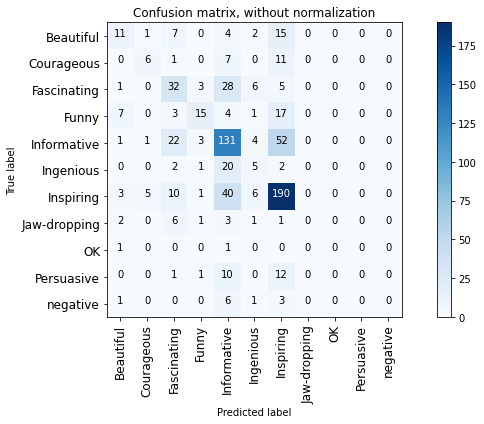

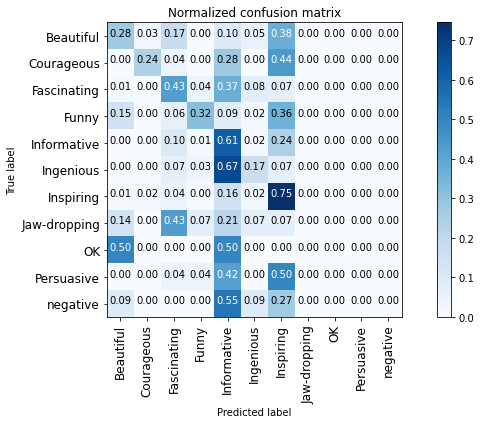

In [45]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

class_names = rf_weight.classes_
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90,fontsize = 12)
    plt.yticks(tick_marks, classes, rotation=0, fontsize = 12)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize = (10,6))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
#plt.savefig('figures/RF_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure(figsize = (10,6))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
#plt.savefig('figures/RF_cm_proportion_multi_class.png', bbox_inches="tight")
plt.show()

### AUC-ROC and Precision-Recall for Multi-Class Classification

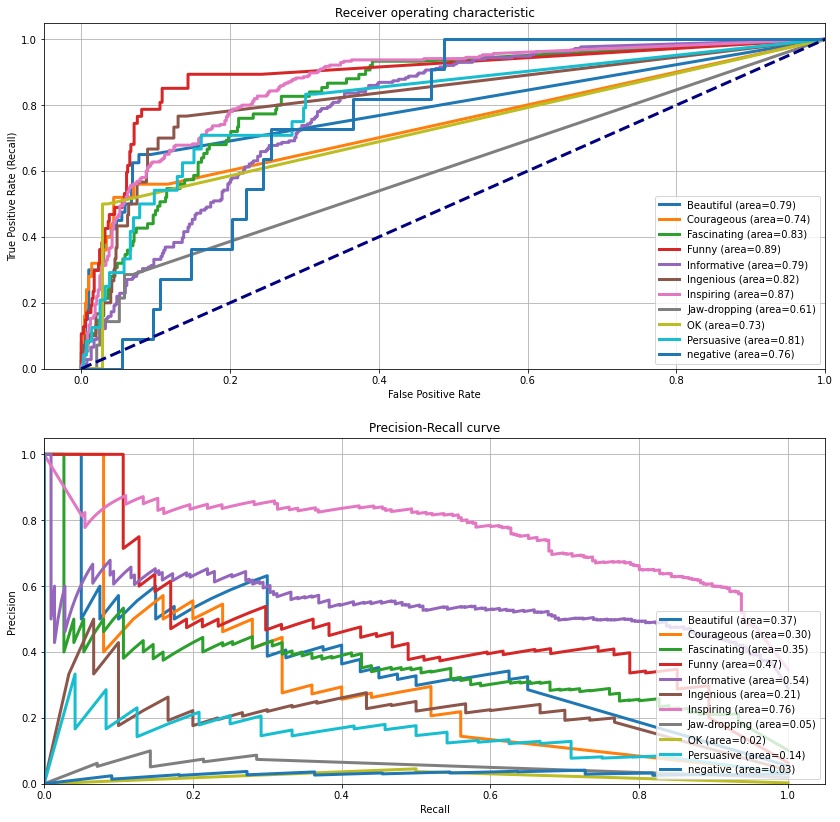

In [56]:
fig, ax = plt.subplots(nrows=2, ncols=1,figsize = (14,14))
classes = rf_weight.classes_
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="lower right")
ax[1].grid(True)
plt.show()

### Conclusion

Our work started with merging the two datasets ted_main.csv and transcripts.csv and then the data cleaning process, during which we changed the original order of data columns for convenience and date columns from the Unix timestamps into a human readable format timestamp. And then checked for the Null values, duplicates and dropped the duplicated rows. In the Exploratory Data Analysis section, we analyzed the dataset using plots such as bar plots, box plots and histograms. Furthermore, this section has figured out other significant analysis about our dataset, regarding the most viewed talks of all time, the top 10 speakers and speakers occupations. We also made hypotheses to figure out the relation between views and speakers' occupation. From the ANOVA test, we concluded that There is no statistical significant relationship between views and speakers occupation.We also showed interesting statistics about views, comments distribution and proved their relationship using Pearson correlation statistical test. And we also showed TED Talks distribution over years, months and weekdays, and some of them were a bit surprising. During the analysis we figured out the outliers and did not remove them as they are actual data for our exploratory analysis. We figured out the collinear features through a heat map. We also analysed several other pairs for a meaningful correlation but they do not seemed to be strongly correlated. We showed the duration distribution and observed that the short duration TED talks are more famous, it is more likely that people are interested in shorter duration talks because they are able to grasp the talk’s content easily or they don’t have time to watch longer duration talks. We also analyzed the ratings features and visualized the top 10 most funniest, beautiful, inspiring, jaw-dropping and confusing talks of all time. We investigated the TED wordcloud to know about which words are most often used by TED Speakers as well as TED themes and occupations. 

Next we moved on to the preprocessing step, there we did feature extraction and feature engineering on the dataset. And then we did text preprocessing on the transcript which includes converting all letters to lower or upper case, converting numbers into words or removing numbers, removing punctuations, accent marks and other diacritics, removing white spaces, removing stop words, sparse terms and particular words. We did sentiment analysis on transcript and derived appropriate rating categories for transcripts from rating feature. And then we visualized the ratings categories with respect to sentiment.

Next we applied summarization algorithms using spaCy, Gensim and sumy(LexRank,LSA,etc) to extract the summary from the transcript. We found that summarization with spaCy gave good results compared to others for this dataset. And then we moved onto the Recommendation system, where we created word vectorizer using Tfidf Vectorizer on transcript, then calculated the cosine similarity to find out how similar the TED Talks are to each other and then we built a recommender function based on cosine similarity to get the top 10 most similar talks.

Next we applied Topic Modelling algorithms LDA(Latent Dirichlet Allocation) and NMF(Non-negative Matrix Factorization) on the transcript data to derive the topics around which most of the famous TED talks are presented . We identified NMF gave better results than LDA for this dataset. Finally we moved on to the prediction model to predict the rating of TED Talks. On applying predictive modelling on the final dataset, we find that of all classifiers used to train the model, Random Forest gives the best results with an accuracy score of 54% and F1(weighted) score of 50%. We used various classifiers like Random Forest, SVM, Logistic Regression and SGDClassifier on 80:20 split to train and test the model and Random Forest out performed among all. 

**In conclusion, our work led to interesting results, analysis and statistics, but also provided useful tools both for audience and speakers, which allows a better understanding of TED Talks dataset.** 

This project gave me an opportunity to explore this freely available dataset using NLP and a proper data science pipeline of data wrangling, data analysis, data visualization, prediction, and data storytelling.


### Future Improvements

- The recommendation engines used by the official ted page, will be a degree of magnitude more sophisticated than what we demonstrated here and would also involve use of some sort of historical user-item interaction data. Would love to try the TED Talk recommendation system using historical user-item interaction data if available.

- Further analysis can be done over the rating column in the dataset to relate the negative comments with topics of TED talk, and find the area of talk which has received more negative feedback. 

- We can also make some more analysis over topic and area of TED Talk, by combining some other datasets like news article, social media post etc to find for any pattern between how the hot discussed topics over world found from news article and social media post are included in TED talk topics, around the same time frame as of the hot discussion over the world. 

- Further we can use the most advanced technologies like deep learning and Neural Networks  to boost the accuracy of our prediction model.
